In [0]:
# simple generative adversarial network
# this version uses the celeba celebrity faces dataset

In [36]:
# mount drive to access csv files

from google.colab import drive
drive.mount('./my_data')

Drive already mounted at ./my_data; to attempt to forcibly remount, call drive.mount("./my_data", force_remount=True).


In [0]:
# conventional PyTorch imports
import torch
import torch.nn as nn
#import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [0]:
import random
import pandas
import numpy
import matplotlib.pyplot as plt
import h5py

In [39]:
# GPU

#torch.cuda.is_available()
#torch.cuda.get_device_name(0)

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

using cuda: Tesla T4


device(type='cuda')

In [40]:
# function to generate normally-distributed random data
# size parameter is length of tensor

def generate_random(size):
    #return torch.rand(size)
    return torch.randn(size)

generate_random(5)

tensor([ 0.8023, -0.7139, -0.3728, -0.1663, -0.3532])

In [0]:
# dataset class

class CelebADataSet(torch.utils.data.Dataset):
    
    def __init__(self, file):
        self.fh = h5py.File(file, 'r')
        self.dataset = self.fh['img_align_celeba']
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        # image data
        imn = list(self.dataset.keys())[index]
        img = numpy.array(self.dataset[imn])
        return torch.cuda.FloatTensor(img) / 255.0
    
    def plot_image(self, index):
        imn = list(self.dataset.keys())[index]
        plt.imshow(numpy.array(self.dataset[imn]), interpolation='nearest')
        pass
    
    def plot_images(self):
        # plot a 3 column, 2 row array of sample images
        f, axarr = plt.subplots(2,3, figsize=(16,8))
        for i in range(2):
            for j in range(3):
                idx = random.randint(0,len(celeba_dataset))
                imn = list(self.dataset.keys())[idx]
                axarr[i,j].imshow(numpy.array(self.dataset[imn]), interpolation='nearest')
                pass
            pass
        pass
    
    pass


In [0]:
# subclass PyTorch dataset class, loads actual data, parses it into targets and pizel data

celeba_dataset = CelebADataSet('my_data/My Drive/Colab Notebooks/gan/celeba_dataset/celeba_aligned_small.h5py')

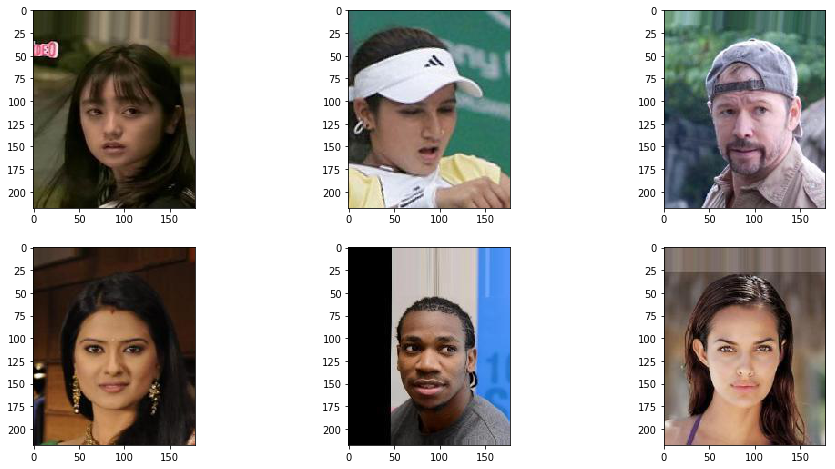

In [43]:
# images are of size (218, 178, 3)
celeba_dataset.plot_images()

In [0]:
# from https://github.com/pytorch/vision/issues/720

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [0]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        # input shape is (1, 3, height, width)
        self.model = nn.Sequential(
            
            View((1,3*218*178)),
            
            nn.Linear(3*218*178, 100),
            nn.LeakyReLU(),
            
            nn.LayerNorm(100),
            
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
        
        # create error function
        self.error_function = torch.nn.BCELoss()

        # create optimiser, using simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        
        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate error
        loss = self.error_function(outputs, targets)
        
        # increase counter and accumulate error every 10
        self.counter += 1;
        self.progress.append(loss.item())
        

        # zero gradients, perform a backward pass, and update the weights.
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    def save(self, path):
        torch.save(self.state_dict(), path)
        pass
    
    
    def load(self, path):
        self.load_state_dict(torch.load(path))
        #self.eval()
        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

In [0]:
%%time 

# create Discriminator and test it

D = Discriminator()
D.to(device)

# train Discriminator

epochs = 1

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    
    count = 1
    for image_data_tensor in celeba_dataset:
        
        # train discriminator on real data
        D.train(image_data_tensor.permute(2,0,1).contiguous().view(1, 3, 178, 218), torch.cuda.FloatTensor([1.0]).view(1,1))
        
        # train discriminator on false (random) data
        D.train(generate_random(3*178*218).view((1, 3, 178, 218)), torch.cuda.FloatTensor([0.0]).view(1,1))
        
        if (count % 1000 == 0):
          print("count = ", count)
          pass
        count += 1
    
        pass
    
    pass


training epoch 1 of 1
count =  1000
count =  2000
count =  3000
count =  4000
count =  5000
count =  6000
count =  7000
count =  8000
count =  9000
count =  10000
count =  11000
count =  12000
count =  13000
count =  14000
count =  15000
count =  16000
count =  17000
count =  18000
count =  19000
CPU times: user 6min 41s, sys: 58.3 s, total: 7min 40s
Wall time: 7min 41s


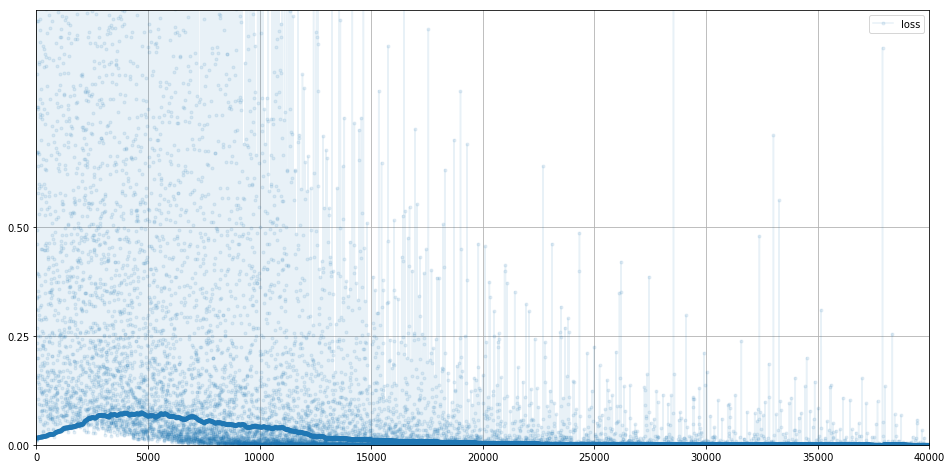

In [0]:
# plot discriminator error

D.plot_progress()

In [0]:
# manually check D can indeed discriminate between real and fake data

print(D.forward(generate_random(3*178*218).view(1, 3, 218, 178)).item())
print(D.forward(generate_random(3*178*218).view(1, 3, 218, 178)).item())
print(D.forward(generate_random(3*178*218).view(1, 3, 218, 178)).item())
print(D.forward(generate_random(3*178*218).view(1, 3, 218, 178)).item())

print(D.forward(celeba_dataset[random.randint(0,len(celeba_dataset))].permute(2,0,1).contiguous().view(1, 3, 178, 218)).item())
print(D.forward(celeba_dataset[random.randint(0,len(celeba_dataset))].permute(2,0,1).contiguous().view(1, 3, 178, 218)).item())
print(D.forward(celeba_dataset[random.randint(0,len(celeba_dataset))].permute(2,0,1).contiguous().view(1, 3, 178, 218)).item())
print(D.forward(celeba_dataset[random.randint(0,len(celeba_dataset))].permute(2,0,1).contiguous().view(1, 3, 178, 218)).item())

0.02124367281794548
1.0248441867588554e-05
0.013160656206309795
1.2191490872393018e-10
0.9994637370109558
0.9994789958000183
0.9994484782218933
0.9994171857833862


In [0]:
# generator class

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        # input shape is 1-dimensional array
        self.model = nn.Sequential(
            
            nn.Linear(100, 3*10*10),
            nn.LeakyReLU(),
            
            nn.LayerNorm(3*10*10),
            
            nn.Linear(3*10*10, 3*218*178),
            nn.Sigmoid(),
            
            View((1, 3, 218, 178))
        )
        
        # create error function
        self.error_function = torch.nn.BCELoss()

        # create optimiser, using simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        
        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.error_function(d_output, targets)
        
        # increase counter and accumulate error every 10
        self.counter += 1;
        self.progress.append(loss.item())
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, and update the weights.
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass
    
    
    def save(self, path):
        torch.save(self.state_dict(), path)
        pass
    
    
    def load(self, path):
        self.load_state_dict(torch.load(path))
        #self.eval()
        pass
    
    
    def plot_images(self):
        # plot a 3 column, 2 row array of sample images
        f, axarr = plt.subplots(2,3, figsize=(16,8))
        for i in range(2):
            for j in range(3):
                axarr[i,j].imshow(G.forward(generate_random(100)).view(3,218,178).permute(1,2,0).detach().cpu().numpy(), interpolation='none')
                pass
            pass
        pass
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 5.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0))
        pass
    
    pass

torch.Size([218, 178, 3])


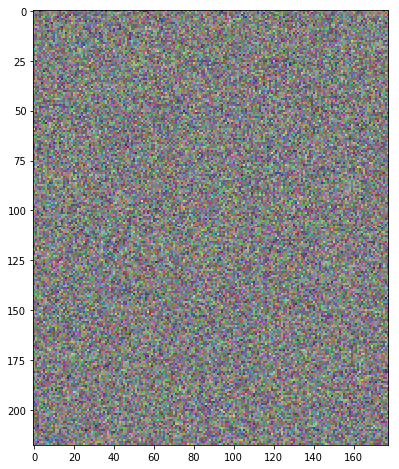

In [48]:
# scratch

G = Generator()
G.to(device)

print(G(generate_random(100)).view(3,218,178).permute(1,2,0).shape)

plt.figure(figsize = (16,8))

plt.imshow(G.forward(generate_random(100)).view(3,218,178).permute(1,2,0).detach().cpu().numpy(), interpolation='none')

In [130]:
# create Discriminator and Generator

D = Discriminator()
D.to(device)

G = Generator()
G.to(device)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=300, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): LayerNorm(torch.Size([300]), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=300, out_features=116412, bias=True)
    (4): Sigmoid()
    (5): View()
  )
  (error_function): BCELoss()
)

In [131]:
%%time 

# train Discriminator and Generator

epochs = 2

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    
    for image_data_tensor in celeba_dataset:
      
        # train discriminator on real data
        D.train(image_data_tensor.permute(2,0,1).contiguous().view(1, 3, 218, 178), torch.cuda.FloatTensor([1.0]).view(1,1))
        
        # train discriminator on false
        # use detach() so only D is updated, not G
        # label softening doesn't apply to 0 labels
        D.train(G.forward(generate_random(100)).detach(), torch.cuda.FloatTensor([0.0]).view(1,1))
        
        # train generator
        G.train(D, generate_random(100), torch.cuda.FloatTensor([1.0]).view(1,1))
        
        pass
    
    pass


training epoch 1 of 2
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
training epoch 2 of 2
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
CPU times: user 17min 18s, sys: 3min 28s, total: 20min 46s
Wall time: 20min 55s


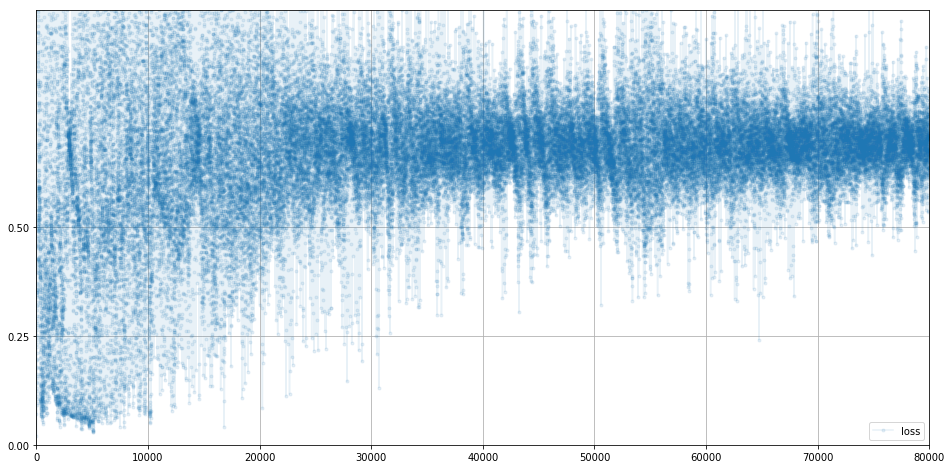

In [132]:
# plot discriminator error

D.plot_progress()

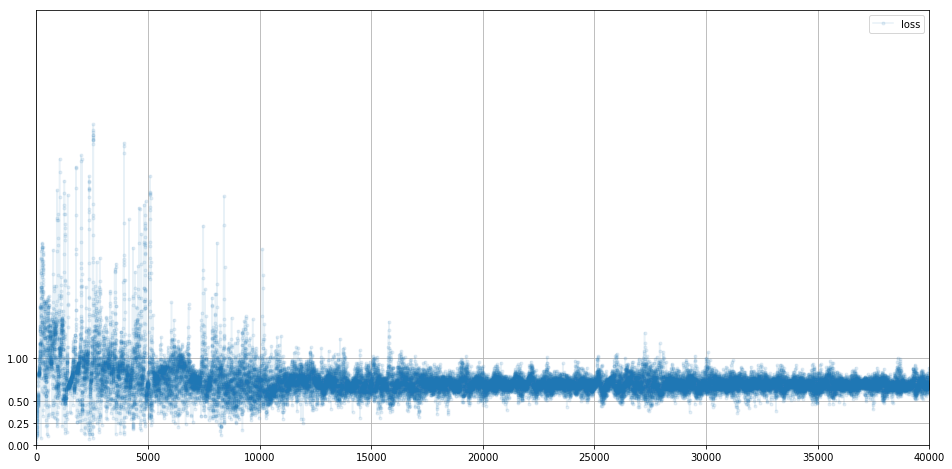

In [133]:
# plot generator error

G.plot_progress()

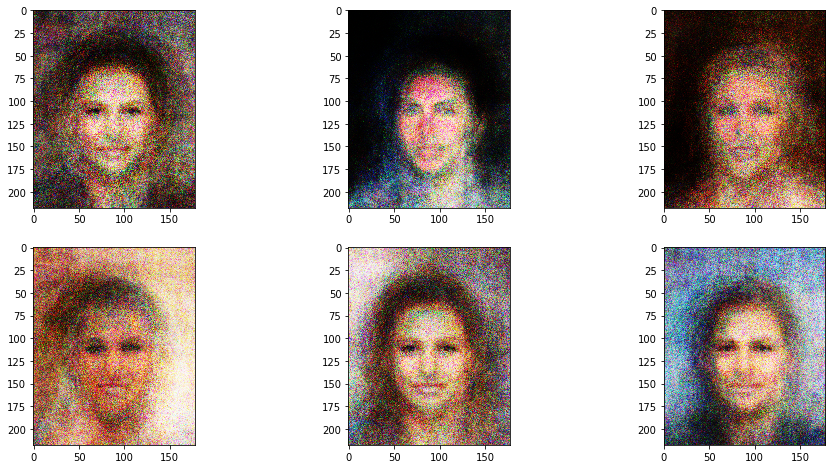

In [134]:
# show generator output

G.plot_images()

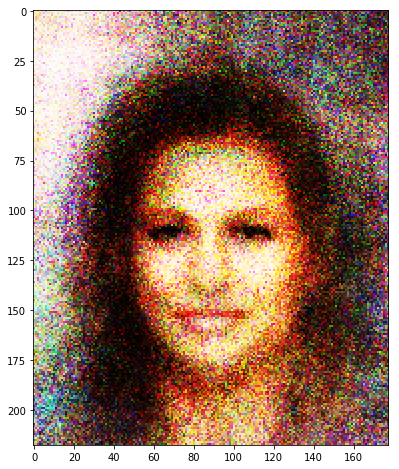

In [135]:
## expts

seed = torch.zeros(100)

seed[random.randint(0,99)] = 1
#seed[70:79] = 1


plt.figure(figsize = (16,8))
plt.imshow(G.forward(seed).view(3,218,178).permute(1,2,0).detach().cpu().numpy(), interpolation='none')
